In [10]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [11]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [12]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import data.Datasets
import models.Feedforward
import models.Attention
import utils.train

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 4

batch_size = 2**13  # = 8192

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\RBF\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\RBF\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)

In [6]:
# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 20

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='mean')

model

ToyModel(
  (linear1): Linear(in_features=245, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear_output): Linear(in_features=32, out_features=1, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

Epoch 000		Train Loss: 1.2245		Val Loss: 7.8311 		LR: 0.002		Time: 82.36111354827881
Epoch 001		Train Loss: 1.0183		Val Loss: 0.36013 		LR: 0.002		Time: 85.20504713058472
Epoch 002		Train Loss: 0.9817		Val Loss: 0.45716 		LR: 0.002		Time: 88.40537548065186
Epoch 003		Train Loss: 0.9761		Val Loss: 2.1687 		LR: 0.002		Time: 94.17261719703674
Epoch 004		Train Loss: 0.97217		Val Loss: 1.1873 		LR: 0.001		Time: 88.20178270339966
Epoch 005		Train Loss: 0.96294		Val Loss: 0.37969 		LR: 0.001		Time: 88.71805810928345
Epoch 006		Train Loss: 0.95704		Val Loss: 0.35104 		LR: 0.001		Time: 90.70333409309387
Epoch 007		Train Loss: 0.9542		Val Loss: 0.4007 		LR: 0.001		Time: 88.07154369354248
Epoch 008		Train Loss: 0.95294		Val Loss: 0.50577 		LR: 0.001		Time: 90.56394052505493
Epoch 009		Train Loss: 0.9515		Val Loss: 1.2294 		LR: 0.0005		Time: 79.10582780838013
Epoch 010		Train Loss: 0.94687		Val Loss: 1.8525 		LR: 0.0005		Time: 82.56773209571838
Epoch 011		Train Loss: 0.94491		Val Loss: 1.8891 		LR

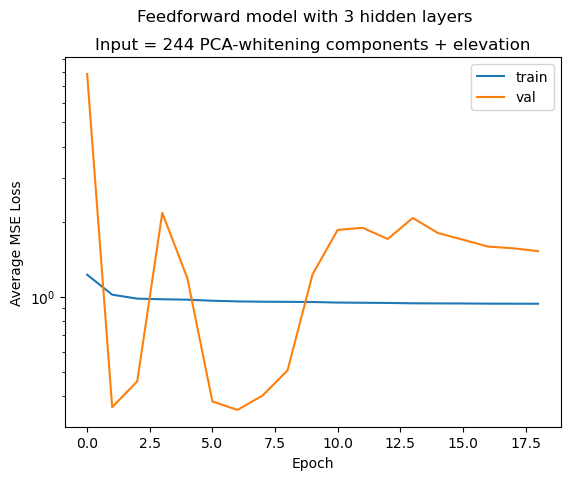

In [9]:
fig, ax = plt.subplots()
fig.suptitle('Feedforward model with 3 hidden layers')
ax.set_title('Input = 244 PCA-whitening components + elevation')
ax.semilogy(np.arange(len(train_loss)), train_loss, label='train')
ax.semilogy(np.arange(len(val_loss)), val_loss, label='val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)